# Baseball Win Predictions

In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import csv
import gameSentiment as gs

# directory containing the CSVs
DATA_PATH = 'Data/baseball/yankees/'
LABEL_FILE_NAME = 'labelfile.csv'
LABEL_FILE_PATH = join(DATA_PATH, LABEL_FILE_NAME)
MODEL = join(DATA_PATH, 'GoogleNews-vectors-negative300.bin')

### Collecting all CSV files 
##### Format:
tweet text, # retweets, # favorites

##### Notes on the CSV files:
- Each CSV for the series contains 10,000 tweets

In [2]:
import re

files = list()
for f in listdir(DATA_PATH):
    if isfile(join(DATA_PATH, f)) and f[-3:] == 'tsv':
        with open(join(DATA_PATH, f)) as of:
            files.append({
                'seriesid': f[:-4],
                'text': [re.sub('\s+', ' ', line) for line in of]
            })

### Collecting the label file
##### Format:
series id (CSV File Name), label (0-1)

##### Notes on the label:
- A series consists of multiple games played over the course of several consecutive days. If our team wins, we consider the label to be *1*. If our team loses, we consider the label to be *0*.
- If a series consists of 3 games and our team wins two and loses one, the label is *0.66*.

In [3]:
label_file = pd.read_csv(LABEL_FILE_PATH, delimiter='\t', names=['seriesid','label'])

## Next step:
- Create a word vector for each tweet in each series:
    - Each word vector must consider sentiment (Zach)
    - Each word vector must consider retweets and favorites (Meaghan)
- Average these word vectors for an 'overall' sentiment of the series.

### After this:
- Create a numpy array containing each 'overall' sentiment vector for each series. (X)
- Create another numpy array of the same size as the X. This time fill  the array with the labels corresponding to each element (series) in X. (y)

In [4]:
from gensim.models.keyedvectors import KeyedVectors

# load the model to vectorize tweets
model = KeyedVectors.load_word2vec_format(MODEL, binary=True)

In [5]:
# computes the word vector for each word in the sentence.
# averages together all of the word vectors and returns the average
def sentence_to_vector(model, sentence):
    words = [model[w] for w in sentence if w in model]
    if len(words) != 0:
        sum = words[0]
        for i in range(1, len(words)):
            sum = sum + words[i]
        return sum / len(words)
    return None

#### Compute the average of all of the tweet vectors which are the average of each word vector
- This is where we need to take into account retweets and favorites

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

series_vectors = list()
for file in files:
    tweets_vector = list()
    for tweet in file['text']:
        if tweet != ' ':
            tweets_vector.append(scaler.fit_transform(sentence_to_vector(model, tweet).reshape(-1,1)) * gs.getSentiment(tweet))
    series_vectors.append({
        'seriesid': file['seriesid'],
        'tweets_vector': tweets_vector
    })

In [7]:
average_series = list()
for series in series_vectors:
    sum = series['tweets_vector'][0]
    for i in range(1, len(series['tweets_vector'])):
        sum = sum + series['tweets_vector'][i]
    average_series.append({
        'seriesid': series['seriesid'],
        'average_vector': sum / len(series['tweets_vector'])
    })

#### Creating X

In [8]:
temp = [x['average_vector'] for x in sorted(average_series, key=lambda x: x['seriesid'])]
X = list()
for x in temp:
    a = list()
    for item in x:
        a.append(item[0])
    X.append(a)
len(X[0])

300

#### Creating y

In [9]:
y = list(label_file.sort_values('seriesid')['label'])

In [10]:
len(X)

52

In [11]:
len(y)

52

### Now we need to split the 52 series into *training* and *test* sets

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Stochastic Gradient Descent Classifier

In [13]:
from sklearn.linear_model import SGDClassifier
import numpy as np

clf = SGDClassifier()
clf.fit(X_train, np.asarray(y_train, dtype='|S9'))

sgd_predictions = clf.predict(X_test)

/home/ltnewberry/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, np.asarray(y_train, dtype='|S9'))

rfc_predictions = clf.predict(X_test)

### True Labels:

In [15]:
for i, y in enumerate(y_test): print(i, ':', y)

0 : 1.0
1 : 0.0
2 : 1.0
3 : 0.6666666667
4 : 0.6666666667
5 : 0.3333333333
6 : 0.5
7 : 0.6666666667
8 : 1.0
9 : 0.75
10 : 0.3333333333


#### SGD Predictions

In [16]:
for i, y in enumerate(sgd_predictions): print(i, ':', y)

0 : b'1.0'
1 : b'0.3333333'
2 : b'0.3333333'
3 : b'1.0'
4 : b'1.0'
5 : b'1.0'
6 : b'0.3333333'
7 : b'0.3333333'
8 : b'1.0'
9 : b'1.0'
10 : b'1.0'


#### RFC Predictions

In [17]:
for i, y in enumerate(rfc_predictions): print(i, ':', y)

0 : b'0.6666666'
1 : b'0.6666666'
2 : b'0.25'
3 : b'0.6666666'
4 : b'0.6666666'
5 : b'0.3333333'
6 : b'0.3333333'
7 : b'0.5'
8 : b'0.3333333'
9 : b'0.3333333'
10 : b'0.3333333'


### *Average of SGD and RFC Predictions*

In [22]:
avg_predictions = (np.array(sgd_predictions, dtype=float) + np.array(rfc_predictions, dtype=float)) / 2
for i, y in enumerate(avg_predictions): print(i, ':', y)

0 : 0.8333333
1 : 0.49999995
2 : 0.29166665
3 : 0.8333333
4 : 0.8333333
5 : 0.66666665
6 : 0.3333333
7 : 0.41666665
8 : 0.66666665
9 : 0.66666665
10 : 0.66666665


In [26]:
for y1, y2 in zip(y_test, avg_predictions):
    print('True:', y1, '\nPrediction:', y2, '\nDifference:',abs(y1 - y2), '\n\n')

True: 1.0 
Prediction: 0.8333333 
Difference: 0.1666667 


True: 0.0 
Prediction: 0.49999995 
Difference: 0.49999995 


True: 1.0 
Prediction: 0.29166665 
Difference: 0.70833335 


True: 0.6666666667 
Prediction: 0.8333333 
Difference: 0.1666666333 


True: 0.6666666667 
Prediction: 0.8333333 
Difference: 0.1666666333 


True: 0.3333333333 
Prediction: 0.66666665 
Difference: 0.3333333167 


True: 0.5 
Prediction: 0.3333333 
Difference: 0.1666667 


True: 0.6666666667 
Prediction: 0.41666665 
Difference: 0.2500000167 


True: 1.0 
Prediction: 0.66666665 
Difference: 0.33333335 


True: 0.75 
Prediction: 0.66666665 
Difference: 0.08333335 


True: 0.3333333333 
Prediction: 0.66666665 
Difference: 0.3333333167 




In [63]:
sum = 0;
for y1, y2 in zip(y_test, avg_predictions):
    sum = sum + abs(y1 - y2)
print(sum / len(y_test))

0.291666665155


In [69]:
import matplotlib.pyplot as plt

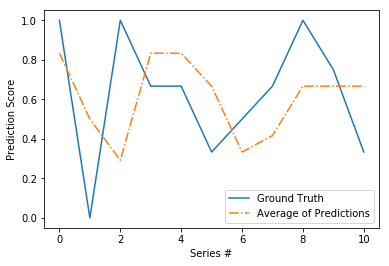

In [70]:
plt.plot(range(len(y_test)), y_test, label="Ground Truth")
plt.plot(range(len(avg_predictions)), avg_predictions, linestyle='-.', label="Average of Predictions")
plt.legend()
plt.ylabel('Prediction Score')
plt.xlabel('Series #')
plt.savefig('GroundTruthVSAvgPrediction.png', dpi=1000)
plt.show()

In [ ]:
plt.plot(range(len(sgd_predictions)), sgd_predictions, label="SGD Predictions")
plt.plot(range(len(rfc_predictions)), rfc_predictions, label="Random Forest Predictions")
plt.plot(range(len(avg_predictions)), avg_predictions, linestyle='-.', label="Avg Predictions")
plt.legend()
plt.ylabel('Prediction Score')
plt.xlabel('Series #')
plt.savefig('AveragingOfPredictionModels.png', dpi=1000)
plt.show()